In [48]:
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib import colors as colors
import numpy as np
import tensorflow as tf

import logging
logging.getLogger("tensorflow").setLevel(logging.ERROR)
tf.autograph.set_verbosity(0)

In [43]:
def load_coffee_data():
    rng = np.random.default_rng(2)
    X = rng.random(400).reshape(-1, 2)
    #reverse scaling
    X[:, 0] = X[:, 0] * (285 - 150) + 150 #temp
    X[:, 1] = X[:, 1] * (16 - 11) + 11 #duration
    
    y = np.zeros((X.shape[0]),)
   
    i = 0
    for temp, dur in X:
        #making the steepest line that indicates the good roast
        y_line = (12 - 15) / (260 - 175 ) * temp + 21
        if (175 < temp < 260) and (12 < dur < 15) and (dur <= y_line):
            y[i] = 1
        else:
            y[i] = 0
        i += 1
        
    return X, y.reshape(-1, 1)
    
X, y = load_coffee_data()
print(X.shape)
print(y.shape)
print(f"First 5 elements of X : \n{X[:5]}")
print(f"Unique elements of Y : \n{np.unique(y)}")

(200, 2)
(200, 1)
First 5 elements of X : 
[[185.31763812  12.49245572]
 [259.92047498  11.45957971]
 [231.01357101  14.64280263]
 [175.3666449   11.27573314]
 [187.12086467  14.28716507]]
Unique elements of Y : 
[0. 1.]


    Let's plot the coffee roasting data below. The two features are Temperature in Celsius and Duration in minutes. Coffee Roasting at Home suggests that the duration is best kept between 12 and 15 minutes while the temp should be between 175 and 260 degrees Celsius. Of course, as the temperature rises, the duration should shrink.

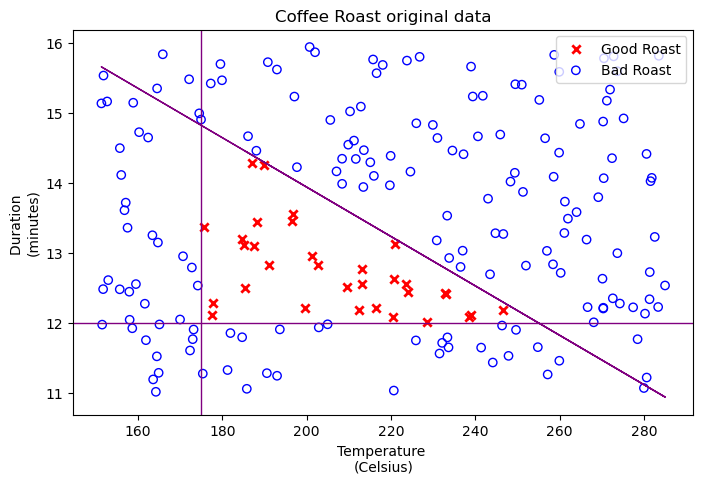

In [47]:
#plotting the original data
def plot_coffee_data(X, y):
    y = y.reshape(-1)
    pos = y==1
    neg = y==0
    fig, ax = plt.subplots(1, 1, figsize=(8, 5))
    ax.scatter(X[pos, 0], X[pos, 1], label="Good Roast", c="r", marker="x", lw=2)
    ax.scatter(X[neg, 0], X[neg, 1], label="Bad Roast", marker="o", lw=1, facecolors="none", edgecolors="blue")
    ax.plot(X[:, 0], (12 - 15) / (260 - 175) * X[:, 0] + 21, lw=1, color="purple")
    ax.axhline(y=12, lw=1, c="purple")
    ax.axvline(x=175, lw=1, c="purple")
    ax.set_xlabel("Temperature \n(Celsius)")
    ax.set_ylabel("Duration \n(minutes)")
    ax.set_title("Coffee Roast original data")
    ax.legend(loc="upper right")
    plt.show()

plot_coffee_data(X, y)

In [16]:
#creating params w's and b's
#first layer with 3 neuron units and input layer with 2 features => 2 w's w1, w2 for each neuron as row place vertically in a matrix
#3 columns cuz of 3 neurons
#b's of that layers will be equal to number of neurons in that layer= 3 b's for first layer
#W1 represents all weights of layer 1
W1 = np.array([[-8.93,  0.29, 12.9],
              [-0.1,  -7.32, 10.81]])
b1 = np.array([-9.82, -9.28,  0.96]) #3 neurons
W2 = np.array([[-31.18],
              [-27.59],
              [-32.56]]) #3 input features for second layer(first layer neurons) placed vertically as row. one column cuz it contains only neuron
b2 = np.array([15.41]) #1 neuron

    Let's build the "Coffee Roasting Network" described in lecture. There are two layers with sigmoid activations. As described in lecture, it is possible to build your own dense layer using NumPy.

In [64]:
#Forward propagation numpy model
def sigmoid(z):
    z = np.clip(z, -500, 500)
    g = 1 / (1 + np.exp(-z))
    return g

def dense_layer(x, W, b, g):
    """
    Computes dense layer
    Args:
      x    (ndarray (n, )) : Input activation Data, 1 example of n features
      W    (ndarray (n, j)) : Weight matrix, n features per unit, j units
      b    (ndarray (j, )) : bias vector, j units  
      g    activation function (e.g. sigmoid, relu..)
    Returns
      activation (ndarray (j,))  : j units|
    """
    units = W.shape[1]
    activation = np.zeros((units),)
    for i in range(units):
        activation[i] = g(np.dot(x, W[:, i]) + b[i])
    return activation
        
def sequential_model(x, W1, b1, W2, b2):
    activation_1 = dense_layer(x, W1, b1, sigmoid) #(3,)
    activation_2 = dense_layer(activation_1, W2, b2, sigmoid) #(1,)
    return activation_2

def predict(X, W1, b1, W2, b2):
    m = X.shape[0]
    output_pred = np.zeros((m, 1)) #(200, 1)
    for i in range(m):
        output_pred[i, 0] = sequential_model(X[i], W1, b1, W2, b2)
    return output_pred
    
#copied trained weights and biases from the previous lab in Tensorflow.
W1 = np.array([[-8.93,  0.29, 12.9],
              [-0.1,  -7.32, 10.81]])
b1 = np.array([-9.82, -9.28,  0.96])
W2 = np.array([[-31.18],
              [-27.59],
              [-32.56]])
b2 = np.array([15.41])
X, y = load_coffee_data()

In [65]:
#normalize the data before using the model
print(f"Temperature Max, Min pre normalization: {np.max(X[:,0]):0.2f}, {np.min(X[:,0]):0.2f}")
print(f"Duration    Max, Min pre normalization: {np.max(X[:,1]):0.2f}, {np.min(X[:,1]):0.2f}")
norm_layer = tf.keras.layers.Normalization(axis=-1)
norm_layer.adapt(X)  # learns mean, variance
X_scaled = norm_layer(X)
print(f"Temperature Max, Min post normalization: {np.max(X_scaled[:,0]):0.2f}, {np.min(X_scaled[:,0]):0.2f}")
print(f"Duration    Max, Min post normalization: {np.max(X_scaled[:,1]):0.2f}, {np.min(X_scaled[:,1]):0.2f}")

Temperature Max, Min pre normalization: 284.99, 151.32
Duration    Max, Min pre normalization: 15.94, 11.02
Temperature Max, Min post normalization: 1.66, -1.69
Duration    Max, Min post normalization: 1.79, -1.70


In [66]:
y_hat = predict(X_scaled, W1, b1, W2, b2) #training data inference
y_hat_t = (y_hat > 0.5).astype(int)

In [67]:
#test data inference
X_test = np.array([
    [200, 13.9], #positive example
    [200, 17], #negative example
])
X_test_norm = norm_layer(X_test)
y_preds = predict(X_test_norm, W1, b1, W2, b2)
y_preds_t = (y_preds > 0.5).astype("int")
print(y_preds_t)

[[1]
 [0]]


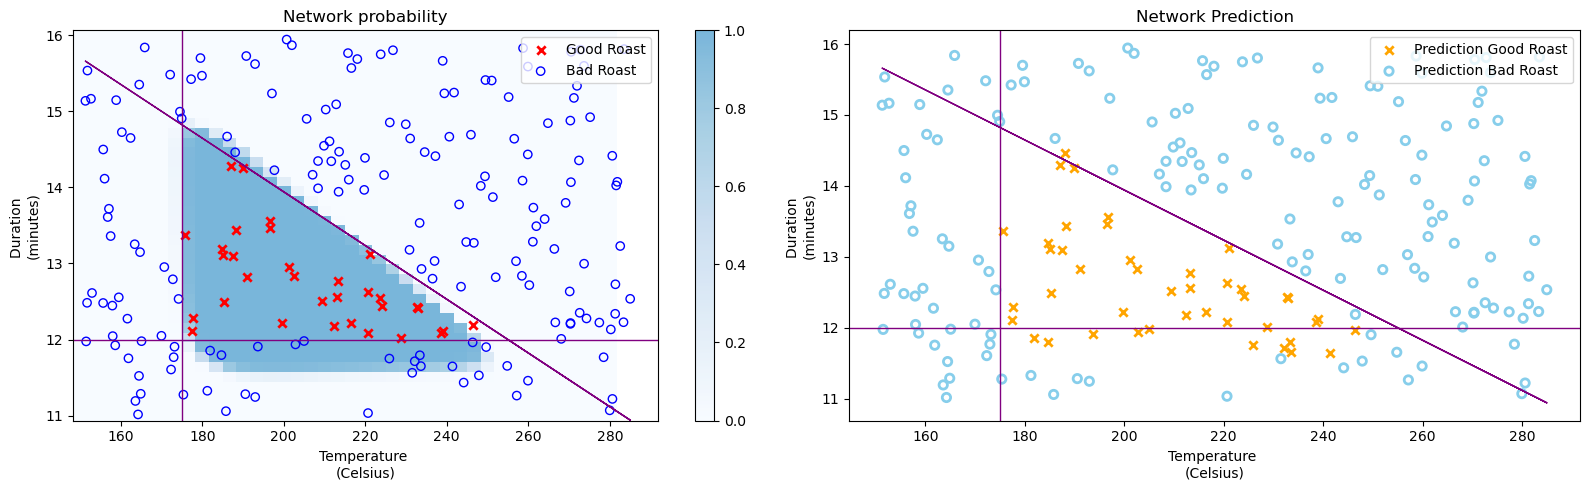

In [69]:
#plotting the whole network
def truncate_color_map(cmap, minval, maxval, n=100):
    new_cmap = colors.LinearSegmentedColormap.from_list(
        "trunc({n}, {a:.2f}, {b:.2f})".format(n=cmap.name, a=minval, b=maxval),
        cmap(np.linspace(minval, maxval, n))
    )
    return new_cmap

def plt_probs(f_wb, ax):
    #creating the spaces
    x0 = np.linspace(150, 280, 40)
    x1 = np.linspace(11, 16, 40)
    
    temp_x0, temp_x1 = np.meshgrid(x0, x1)
    z = np.zeros_like(temp_x0)
    for i in range(len(x0)):
        for j in range(len(x1)):
            inp = np.array([[temp_x0[i, j], temp_x1[i, j]]])
            z[i, j] = f_wb(inp)
    cmap = plt.get_cmap("Blues")
    new_cmap = truncate_color_map(cmap, 0.0, 0.5)
    pcm = ax.pcolormesh(temp_x0, temp_x1, z,
                       alpha=0.9, shading="nearest", cmap=new_cmap,
                       norm=cm.colors.Normalize(vmin=0, vmax=1))
    ax.figure.colorbar(pcm, ax=ax)
    
def plot_network(X, y, f_wb):
    y = y.reshape(-1)
    pos = y==1
    neg = y==0
    fig, ax = plt.subplots(1, 2, figsize=(16, 5))
    plt_probs(f_wb, ax[0])
    ax[0].scatter(X[pos, 0], X[pos, 1], label="Good Roast", c="r", marker="x", lw=2)
    ax[0].scatter(X[neg, 0], X[neg, 1], label="Bad Roast", marker="o", lw=1, facecolors="none", edgecolors="blue")
    ax[0].plot(X[:, 0], (12 - 15) / (260 - 175) * X[:, 0] + 21, lw=1, color="purple")
    ax[0].axhline(y=12, lw=1, c="purple")
    ax[0].axvline(x=175, lw=1, c="purple")
    ax[0].set_xlabel("Temperature \n(Celsius)")
    ax[0].set_ylabel("Duration \n(minutes)")
    ax[0].set_title("Network probability")
    ax[0].legend(loc="upper right")
    
    y_hat = f_wb(X)
    y_hat_t = (y_hat > 0.5).astype(int)
    y_hat_t = y_hat_t.reshape(-1)
    pos = y_hat_t==1
    neg = y_hat_t==0
    ax[1].scatter(X[pos, 0], X[pos, 1], label="Prediction Good Roast", c="orange", marker="x", lw=2)
    ax[1].scatter(X[neg, 0], X[neg, 1], label="Prediction Bad Roast", marker="o", lw=2, facecolors="none", edgecolors="skyblue")
    ax[1].plot(X[:, 0], (12 - 15) / (260 - 175) * X[:, 0] + 21, lw=1, color="purple")
    ax[1].axhline(y=12, lw=1, c="purple")
    ax[1].axvline(x=175, lw=1, c="purple")
    ax[1].set_xlabel("Temperature \n(Celsius)")
    ax[1].set_ylabel("Duration \n(minutes)")
    ax[1].set_title("Network Prediction")
    ax[1].legend(loc="upper right")
    
    plt.tight_layout()
    plt.show()

f_wb = lambda x : predict(norm_layer(x), W1, b1, W2, b2)

plot_network(X, y, f_wb)

    This graph shows the operation of the whole network and is identical to the Tensorflow result from the previous lab. The left graph is the raw output of the final layer represented by the blue shading. This is overlaid on the training data represented by the X's and O's.The right graph is the output of the network after a decision threshold. The X's and O's here correspond to decisions made by the network.